In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Transformações aplicadas a todas as imagens
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),                        
    transforms.Normalize((0.5, 0.5, 0.5),          # centrado em 0, intervalo [-1, 1]
                         (0.5, 0.5, 0.5))
])

# Carregar o conjunto CIFAR-100 (apenas treino)
full_trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(full_trainset))   # 40.000
val_size = len(full_trainset) - train_size  # 10.000
trainset, valset = random_split(full_trainset, [train_size, val_size])

# Conjunto de teste separado
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)
testloader  = DataLoader(testset,  batch_size=64, shuffle=False, num_workers=1)

# Info auxiliar
classes = full_trainset.classes
num_classes = len(classes)

print(f"Total de classes: {num_classes}")
print(f"Tamanho do treino: {len(trainset)}")
print(f"Tamanho da validação: {len(valset)}")
print(f"Tamanho do teste: {len(testset)}")


Total de classes: 100
Tamanho do treino: 40000
Tamanho da validação: 10000
Tamanho do teste: 10000


In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder  # Corrigido: agora ImageFolder está importado corretamente
import torch
from torch.utils.data import DataLoader

# Transformações: resize para 64x64, normalização
transform = transforms.Compose([
    transforms.Resize((64, 64)),                # Redimensionamento para 64x64
    transforms.ToTensor(),                        # Converte para tensor [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5),         # Normalização com médias e desvios padrões
                         (0.5, 0.5, 0.5))
])

# Defina o diretório local onde está o seu dataset
train_dir = "datasets/GRv2P/train"   # Substitua com o caminho para o diretório de treino
test_dir = "datasets/GRv2P/val"     # Substitua com o caminho para o diretório de teste

# Usando ImageFolder para carregar o dataset
trainset = ImageFolder(root=train_dir, transform=transform)
testset = ImageFolder(root=test_dir, transform=transform)

# Carregar os dados com DataLoader
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=1)

# Classes (rótulos) do dataset
classes = trainset.classes
num_classes = len(classes)

print(f"Classes: {classes}")
print(f"Classes: {num_classes}")


Classes: ['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney', 'Crosswalk', 'Hydrant', 'Motorcycle', 'Other', 'Palm', 'Stair', 'Traffic Light']
Classes: 12


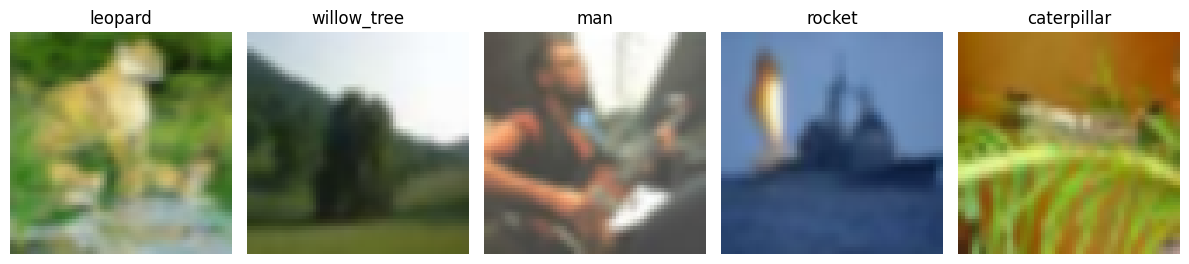

In [17]:
import matplotlib.pyplot as plt
import torch
import random
import numpy as np

# Função para desnormalizar (ajuste se for grayscale)
def denormalize(img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    if img.shape[0] == 1:
        mean = torch.tensor([mean[0]]).reshape(-1, 1, 1)
        std = torch.tensor([std[0]]).reshape(-1, 1, 1)
    else:
        mean = torch.tensor(mean).reshape(-1, 1, 1)
        std = torch.tensor(std).reshape(-1, 1, 1)
    return img * std + mean

indices = random.sample(range(len(testset)), 5)

plt.figure(figsize=(12, 3))
for i, idx in enumerate(indices):
    img, label = testset[idx]
    # Desnormaliza antes de exibir
    img = denormalize(img)
    img_np = img.squeeze().numpy()
    if img_np.ndim == 2:
        plt.subplot(1, 5, i+1)
        plt.imshow(img_np, cmap='gray', vmin=0, vmax=1)
    else:
        plt.subplot(1, 5, i+1)
        plt.imshow(np.transpose(img_np, (1, 2, 0)), vmin=0, vmax=1)
    plt.title(testset.classes[label])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [18]:
import torch
import torch.nn as nn

class CRNNClassifier(nn.Module):
    def __init__(self, num_classes=100):
        super(CRNNClassifier, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # entrada RGB
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x16

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 8x8
        )

        self.rnn = nn.LSTM(input_size=256*8, hidden_size=128, num_layers=1, batch_first=True, bidirectional=True)

        self.fc = nn.Linear(128 * 2, num_classes)

    def forward(self, x):
        x = self.cnn(x)  # [B, C, H, W]
        b, c, h, w = x.size()
    
        # Reduz para [B, T, Features] para LSTM
        # Aqui T = H (linhas), Features = W * C
        x = x.permute(0, 2, 3, 1).contiguous()  # [B, H, W, C]
        x = x.view(b, h, -1)  # [B, H, W*C]
        
        x, _ = self.rnn(x)  # [B, H, 2*hidden]
        x = x[:, -1, :]     # pega último timestep
        x = self.fc(x)
        return x



In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CRNNClassifier(num_classes=100).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


In [20]:
from tqdm import tqdm

for epoch in range(200):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(trainloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.92it/s]


Epoch 1, Loss: 2605.7040


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 31.58it/s]


Epoch 2, Loss: 2275.2537


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.79it/s]


Epoch 3, Loss: 2079.7744


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.19it/s]


Epoch 4, Loss: 1939.5198


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.93it/s]


Epoch 5, Loss: 1820.6797


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.07it/s]


Epoch 6, Loss: 1715.9165


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.25it/s]


Epoch 7, Loss: 1623.8712


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.30it/s]


Epoch 8, Loss: 1542.4675


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:22<00:00, 27.99it/s]


Epoch 9, Loss: 1467.6022


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:20<00:00, 30.92it/s]


Epoch 10, Loss: 1402.0038


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.16it/s]


Epoch 11, Loss: 1338.6387


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.47it/s]


Epoch 12, Loss: 1279.5261


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.83it/s]


Epoch 13, Loss: 1224.2285


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.75it/s]


Epoch 14, Loss: 1168.5695


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:20<00:00, 30.80it/s]


Epoch 15, Loss: 1114.0442


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:20<00:00, 30.06it/s]


Epoch 16, Loss: 1066.7118


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.25it/s]


Epoch 17, Loss: 1014.6427


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.54it/s]


Epoch 18, Loss: 967.2843


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 32.94it/s]


Epoch 19, Loss: 918.2788


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.33it/s]


Epoch 20, Loss: 871.1399


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.44it/s]


Epoch 21, Loss: 824.7163


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:23<00:00, 27.05it/s]


Epoch 22, Loss: 779.5738


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.27it/s]


Epoch 23, Loss: 734.6105


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 31.85it/s]


Epoch 24, Loss: 689.2652


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.34it/s]


Epoch 25, Loss: 646.8093


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.35it/s]


Epoch 26, Loss: 606.7820


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.27it/s]


Epoch 27, Loss: 564.2852


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 36.25it/s]


Epoch 28, Loss: 526.5373


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.79it/s]


Epoch 29, Loss: 488.9744


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.67it/s]


Epoch 30, Loss: 450.3083


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.01it/s]


Epoch 31, Loss: 414.4738


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.69it/s]


Epoch 32, Loss: 381.6404


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.03it/s]


Epoch 33, Loss: 349.1825


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.30it/s]


Epoch 34, Loss: 316.5746


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.37it/s]


Epoch 35, Loss: 291.9296


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.34it/s]


Epoch 36, Loss: 261.1899


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.43it/s]


Epoch 37, Loss: 235.4796


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.87it/s]


Epoch 38, Loss: 211.3916


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.61it/s]


Epoch 39, Loss: 192.7695


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.55it/s]


Epoch 40, Loss: 169.5559


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.81it/s]


Epoch 41, Loss: 152.0867


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.87it/s]


Epoch 42, Loss: 137.2228


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:20<00:00, 30.54it/s]


Epoch 43, Loss: 119.3770


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:20<00:00, 31.07it/s]


Epoch 44, Loss: 110.6829


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.82it/s]


Epoch 45, Loss: 95.6168


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.49it/s]


Epoch 46, Loss: 87.3600


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.91it/s]


Epoch 47, Loss: 78.3040


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.59it/s]


Epoch 48, Loss: 73.6855


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.44it/s]


Epoch 49, Loss: 63.7807


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:22<00:00, 27.54it/s]


Epoch 50, Loss: 55.3443


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:24<00:00, 25.42it/s]


Epoch 51, Loss: 48.6055


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:22<00:00, 27.29it/s]


Epoch 52, Loss: 55.2344


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.22it/s]


Epoch 53, Loss: 39.8182


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:20<00:00, 31.19it/s]


Epoch 54, Loss: 43.7152


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.13it/s]


Epoch 55, Loss: 32.7269


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.29it/s]


Epoch 56, Loss: 38.6057


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.76it/s]


Epoch 57, Loss: 57.9345


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.99it/s]


Epoch 58, Loss: 17.0608


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.65it/s]


Epoch 59, Loss: 15.7599


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.93it/s]


Epoch 60, Loss: 100.9571


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.21it/s]


Epoch 61, Loss: 25.8338


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.34it/s]


Epoch 62, Loss: 12.0631


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.90it/s]


Epoch 63, Loss: 10.4195


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.41it/s]


Epoch 64, Loss: 61.5665


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.67it/s]


Epoch 65, Loss: 62.6334


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.99it/s]


Epoch 66, Loss: 10.9500


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.06it/s]


Epoch 67, Loss: 8.7930


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.42it/s]


Epoch 68, Loss: 8.4165


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.66it/s]


Epoch 69, Loss: 102.5499


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.47it/s]


Epoch 70, Loss: 16.5030


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.43it/s]


Epoch 71, Loss: 8.2935


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.22it/s]


Epoch 72, Loss: 6.8975


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 36.08it/s]


Epoch 73, Loss: 6.8472


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.79it/s]


Epoch 74, Loss: 92.0682


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.28it/s]


Epoch 75, Loss: 47.4289


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.60it/s]


Epoch 76, Loss: 8.3589


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 36.12it/s]


Epoch 77, Loss: 6.3252


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:20<00:00, 30.51it/s]


Epoch 78, Loss: 5.6965


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:20<00:00, 29.92it/s]


Epoch 79, Loss: 5.2424


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 31.39it/s]


Epoch 80, Loss: 115.0566


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.24it/s]


Epoch 81, Loss: 12.7911


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.53it/s]


Epoch 82, Loss: 6.8252


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.35it/s]


Epoch 83, Loss: 5.4528


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.11it/s]


Epoch 84, Loss: 60.6756


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.43it/s]


Epoch 85, Loss: 21.5089


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.31it/s]


Epoch 86, Loss: 6.0399


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.57it/s]


Epoch 87, Loss: 4.5994


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.48it/s]


Epoch 88, Loss: 4.1037


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:20<00:00, 30.14it/s]


Epoch 89, Loss: 3.9445


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:24<00:00, 25.39it/s]


Epoch 90, Loss: 96.1992


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:22<00:00, 27.66it/s]


Epoch 91, Loss: 23.1753


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:23<00:00, 26.59it/s]


Epoch 92, Loss: 6.1760


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.51it/s]


Epoch 93, Loss: 4.4678


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 36.21it/s]


Epoch 94, Loss: 4.0078


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 36.47it/s]


Epoch 95, Loss: 67.6015


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.88it/s]


Epoch 96, Loss: 23.6747


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.69it/s]


Epoch 97, Loss: 5.3710


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.30it/s]


Epoch 98, Loss: 4.0277


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.20it/s]


Epoch 99, Loss: 3.4843


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.25it/s]


Epoch 100, Loss: 3.1472


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.93it/s]


Epoch 101, Loss: 4.1929


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.67it/s]


Epoch 102, Loss: 109.6649


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.36it/s]


Epoch 103, Loss: 6.0421


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.90it/s]


Epoch 104, Loss: 4.1656


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.10it/s]


Epoch 105, Loss: 3.3154


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.63it/s]


Epoch 106, Loss: 2.9440


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.61it/s]


Epoch 107, Loss: 2.6743


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.02it/s]


Epoch 108, Loss: 51.4680


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.85it/s]


Epoch 109, Loss: 55.1543


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.25it/s]


Epoch 110, Loss: 5.3910


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.59it/s]


Epoch 111, Loss: 3.6690


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.14it/s]


Epoch 112, Loss: 3.0370


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 31.32it/s]


Epoch 113, Loss: 2.6409


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.18it/s]


Epoch 114, Loss: 2.4192


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.00it/s]


Epoch 115, Loss: 2.4226


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:20<00:00, 30.97it/s]


Epoch 116, Loss: 105.9117


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:20<00:00, 31.02it/s]


Epoch 117, Loss: 8.7771


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.27it/s]


Epoch 118, Loss: 3.9763


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.05it/s]


Epoch 119, Loss: 3.0557


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.45it/s]


Epoch 120, Loss: 2.5725


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.70it/s]


Epoch 121, Loss: 2.4837


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.41it/s]


Epoch 122, Loss: 80.7295


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.09it/s]


Epoch 123, Loss: 8.8397


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.15it/s]


Epoch 124, Loss: 3.9174


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:20<00:00, 29.83it/s]


Epoch 125, Loss: 2.8334


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.58it/s]


Epoch 126, Loss: 2.3820


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.72it/s]


Epoch 127, Loss: 2.1840


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.83it/s]


Epoch 128, Loss: 72.2934


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.33it/s]


Epoch 129, Loss: 4.9412


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.31it/s]


Epoch 130, Loss: 3.1698


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.74it/s]


Epoch 131, Loss: 2.4808


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 36.29it/s]


Epoch 132, Loss: 2.1828


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 36.41it/s]


Epoch 133, Loss: 2.2082


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 36.50it/s]


Epoch 134, Loss: 83.1723


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 36.27it/s]


Epoch 135, Loss: 6.7620


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.11it/s]


Epoch 136, Loss: 3.3415


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.91it/s]


Epoch 137, Loss: 2.5775


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.39it/s]


Epoch 138, Loss: 2.1396


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.58it/s]


Epoch 139, Loss: 1.9474


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.98it/s]


Epoch 140, Loss: 1.9851


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.19it/s]


Epoch 141, Loss: 87.9031


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.75it/s]


Epoch 142, Loss: 4.9162


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.99it/s]


Epoch 143, Loss: 2.8423


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.66it/s]


Epoch 144, Loss: 2.3361


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.35it/s]


Epoch 145, Loss: 2.0958


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.38it/s]


Epoch 146, Loss: 2.1684


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 31.58it/s]


Epoch 147, Loss: 1.7545


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.74it/s]


Epoch 148, Loss: 62.2724


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.89it/s]


Epoch 149, Loss: 25.5043


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.74it/s]


Epoch 150, Loss: 3.6433


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.48it/s]


Epoch 151, Loss: 2.6600


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.87it/s]


Epoch 152, Loss: 2.2201


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.94it/s]


Epoch 153, Loss: 1.8319


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.77it/s]


Epoch 154, Loss: 1.7600


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.72it/s]


Epoch 155, Loss: 73.5384


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.37it/s]


Epoch 156, Loss: 7.7455


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.42it/s]


Epoch 157, Loss: 3.1124


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.42it/s]


Epoch 158, Loss: 2.3725


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.75it/s]


Epoch 159, Loss: 2.0460


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.61it/s]


Epoch 160, Loss: 1.7289


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.44it/s]


Epoch 161, Loss: 1.7059


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.70it/s]


Epoch 162, Loss: 1.5685


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.99it/s]


Epoch 163, Loss: 16.5436


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.71it/s]


Epoch 164, Loss: 68.2020


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.30it/s]


Epoch 165, Loss: 3.6745


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.05it/s]


Epoch 166, Loss: 2.4603


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.60it/s]


Epoch 167, Loss: 2.0177


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.58it/s]


Epoch 168, Loss: 1.7851


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.83it/s]


Epoch 169, Loss: 1.5856


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 36.05it/s]


Epoch 170, Loss: 1.4921


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.86it/s]


Epoch 171, Loss: 80.3731


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 32.91it/s]


Epoch 172, Loss: 4.2350


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.94it/s]


Epoch 173, Loss: 2.6089


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.73it/s]


Epoch 174, Loss: 1.9732


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.38it/s]


Epoch 175, Loss: 2.0856


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.16it/s]


Epoch 176, Loss: 1.6137


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.01it/s]


Epoch 177, Loss: 1.4437


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.33it/s]


Epoch 178, Loss: 1.3311


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.39it/s]


Epoch 179, Loss: 11.4091


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.17it/s]


Epoch 180, Loss: 71.0665


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.20it/s]


Epoch 181, Loss: 3.3022


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.75it/s]


Epoch 182, Loss: 2.2300


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.78it/s]


Epoch 183, Loss: 1.8295


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.04it/s]


Epoch 184, Loss: 1.6153


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.72it/s]


Epoch 185, Loss: 1.4286


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.57it/s]


Epoch 186, Loss: 59.9761


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:20<00:00, 30.47it/s]


Epoch 187, Loss: 5.5103


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.60it/s]


Epoch 188, Loss: 2.5595


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 34.18it/s]


Epoch 189, Loss: 1.8746


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 33.51it/s]


Epoch 190, Loss: 1.5850


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.26it/s]


Epoch 191, Loss: 1.4144


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:18<00:00, 32.93it/s]


Epoch 192, Loss: 1.3033


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.80it/s]


Epoch 193, Loss: 1.1936


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:21<00:00, 28.52it/s]


Epoch 194, Loss: 70.8602


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:24<00:00, 25.27it/s]


Epoch 195, Loss: 3.4752


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:21<00:00, 28.84it/s]


Epoch 196, Loss: 2.2239


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.98it/s]


Epoch 197, Loss: 1.7674


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 34.97it/s]


Epoch 198, Loss: 1.5049


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:17<00:00, 35.41it/s]


Epoch 199, Loss: 1.4101


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:19<00:00, 32.10it/s]

Epoch 200, Loss: 1.2808


In [21]:
import random
import matplotlib.pyplot as plt

def test_random_image(model, testset, device):
    model.eval()
    idx = random.randint(0, len(testset) - 1)
    image, label = testset[idx]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_input)
        pred = output.argmax(1).item()

    # Mostrar imagem
    plt.imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)) * 0.5 + 0.5)
    plt.title(f"Real: {classes[label]}\nPrevisto: {classes[pred]}")
    plt.axis('off')
    plt.show()


In [22]:
import torch
import time
import numpy as np

model.eval()
top1_correct, top5_correct, total = 0, 0, 0
inference_times = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        start_time = time.time()
        outputs = model(images)
        inference_times.append((time.time() - start_time) / images.size(0))  # tempo médio deste batch

        # Top-1 (igual ao acerto padrão)
        _, preds = torch.max(outputs, 1)
        top1_correct += (preds == labels).sum().item()

        # Top-5
        top5 = torch.topk(outputs, 5, dim=1).indices
        labels_exp = labels.view(-1, 1).expand_as(top5)
        top5_correct += (top5 == labels_exp).sum().item()

        total += labels.size(0)

top1_acc = 100 * top1_correct / total
top5_acc = 100 * top5_correct / total
mean_inf_time = np.mean(inference_times) * 1000  # para ms

print(f"Acurácia Top-1:  {top1_acc:.2f}%")
print(f"Acurácia Top-5:  {top5_acc:.2f}%")
print(f"Tempo médio de inferência por imagem: {mean_inf_time:.2f} ms")


Acurácia Top-1:  44.79%
Acurácia Top-5:  73.13%
Tempo médio de inferência por imagem: 0.02 ms


In [24]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

def carregar_dataset_com_transformacoes(pasta_imagens):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),                        
        transforms.Normalize((0.5, 0.5, 0.5),          # centrado em 0, intervalo [-1, 1]
                             (0.5, 0.5, 0.5))
    ])

    dataset = ImageFolder(root=pasta_imagens, transform=transform)
    return dataset

# Caminho para a pasta onde estão suas imagens organizadas por classe
caminho_val_aug = 'datasets/cifar100/val_aug'

# Carregar o dataset
testset_aug = carregar_dataset_com_transformacoes(caminho_val_aug)


In [27]:
import torch
import random
import numpy as np
from collections import defaultdict
from tqdm import tqdm

def avaliar_grupos(testset, model, device='cpu', n_execucoes=5, n_trials=100, group_size=9, min_class_count=3):
    model.eval()

    # Construir um dicionário: classe -> lista de índices
    class_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(testset):
        class_to_indices[label].append(idx)

    eligible_classes = [cls for cls, idxs in class_to_indices.items() if len(idxs) >= min_class_count]
    print(f"Total de classes elegíveis: {len(eligible_classes)}")

    # Acumuladores gerais
    total_predictions_all = 0
    total_correct_all = 0
    total_grupos_all = 0

    acertos_grupo_total_all = 0
    acertos_grupo_parcial_all = 0
    erros_grupo_total_all = 0

    for exec_num in range(n_execucoes):
        print(f"\n🔁 Execução {exec_num + 1}/{n_execucoes}")
        for _ in tqdm(range(n_trials), desc=f"Grupo de avaliação #{exec_num + 1}"):
            chosen_class = random.choice(eligible_classes)
            class_indices = random.sample(class_to_indices[chosen_class], min_class_count)

            remaining_indices = [i for i in range(len(testset)) if i not in class_indices]
            other_indices = random.sample(remaining_indices, group_size - min_class_count)

            group_indices = class_indices + other_indices
            random.shuffle(group_indices)

            group_class_correct = 0
            group_class_total = 0

            for idx in group_indices:
                img, label = testset[idx]
                img_input = img.unsqueeze(0).to(device)

                with torch.no_grad():
                    output = model(img_input)
                    pred = output.argmax(dim=1).item()

                total_predictions_all += 1
                if pred == label:
                    total_correct_all += 1

                if label == chosen_class:
                    group_class_total += 1
                    if pred == label:
                        group_class_correct += 1

            total_grupos_all += 1
            if group_class_correct == group_class_total:
                acertos_grupo_total_all += 1
            elif group_class_correct > 0:
                acertos_grupo_parcial_all += 1
            else:
                erros_grupo_total_all += 1

    # Resultados finais
    acc_img = total_correct_all / total_predictions_all
    acc_total = acertos_grupo_total_all / total_grupos_all
    acc_parcial = acertos_grupo_parcial_all / total_grupos_all
    erro_total = erros_grupo_total_all / total_grupos_all

    # Exibição
    print(f"\n📊 Resultados em {n_execucoes} execuções ({total_grupos_all} grupos, {total_predictions_all} imagens):")
    print(f"🔹 Acurácia média por imagem: {acc_img:.2%} ({total_correct_all}/{total_predictions_all})")
    print(f"✅ Grupos com acerto total da classe-alvo: {acc_total:.2%} ({acertos_grupo_total_all}/{total_grupos_all})")
    print(f"⚠️ Grupos com acerto parcial da classe-alvo: {acc_parcial:.2%} ({acertos_grupo_parcial_all}/{total_grupos_all})")
    print(f"❌ Grupos com erro total da classe-alvo: {erro_total:.2%} ({erros_grupo_total_all}/{total_grupos_all})")

# Exemplo de chamada:
avaliar_grupos(testset=testset_aug, model=model, device=device, n_execucoes=5)


Total de classes elegíveis: 100

🔁 Execução 1/5


Grupo de avaliação #1: 100%|█████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.12it/s]



🔁 Execução 2/5


Grupo de avaliação #2: 100%|█████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.63it/s]



🔁 Execução 3/5


Grupo de avaliação #3: 100%|█████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.36it/s]



🔁 Execução 4/5


Grupo de avaliação #4: 100%|█████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.45it/s]



🔁 Execução 5/5


Grupo de avaliação #5: 100%|█████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.79it/s]


📊 Resultados em 5 execuções (500 grupos, 4500 imagens):
🔹 Acurácia média por imagem: 86.76% (3904/4500)
✅ Grupos com acerto total da classe-alvo: 64.60% (323/500)
⚠️ Grupos com acerto parcial da classe-alvo: 34.80% (174/500)
❌ Grupos com erro total da classe-alvo: 0.60% (3/500)


In [26]:
import torch
import random
import numpy as np
from collections import defaultdict
from tqdm import tqdm

def avaliar_grupos(testset, model, device='cpu', n_execucoes=5, n_trials=100, group_size=9, min_class_count=3):
    model.eval()

    # Construir um dicionário: classe -> lista de índices
    class_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(testset):
        class_to_indices[label].append(idx)

    eligible_classes = [cls for cls, idxs in class_to_indices.items() if len(idxs) >= min_class_count]
    print(f"Total de classes elegíveis: {len(eligible_classes)}")

    # Acumuladores gerais
    total_predictions_all = 0
    total_correct_all = 0
    total_grupos_all = 0

    acertos_grupo_total_all = 0
    acertos_grupo_parcial_all = 0
    erros_grupo_total_all = 0

    for exec_num in range(n_execucoes):
        print(f"\n🔁 Execução {exec_num + 1}/{n_execucoes}")
        for _ in tqdm(range(n_trials), desc=f"Grupo de avaliação #{exec_num + 1}"):
            chosen_class = random.choice(eligible_classes)
            class_indices = random.sample(class_to_indices[chosen_class], min_class_count)

            remaining_indices = [i for i in range(len(testset)) if i not in class_indices]
            other_indices = random.sample(remaining_indices, group_size - min_class_count)

            group_indices = class_indices + other_indices
            random.shuffle(group_indices)

            group_class_correct = 0
            group_class_total = 0

            for idx in group_indices:
                img, label = testset[idx]
                img_input = img.unsqueeze(0).to(device)

                with torch.no_grad():
                    output = model(img_input)
                    pred = output.argmax(dim=1).item()

                total_predictions_all += 1
                if pred == label:
                    total_correct_all += 1

                if label == chosen_class:
                    group_class_total += 1
                    if pred == label:
                        group_class_correct += 1

            total_grupos_all += 1
            if group_class_correct == group_class_total:
                acertos_grupo_total_all += 1
            elif group_class_correct > 0:
                acertos_grupo_parcial_all += 1
            else:
                erros_grupo_total_all += 1

    # Resultados finais
    acc_img = total_correct_all / total_predictions_all
    acc_total = acertos_grupo_total_all / total_grupos_all
    acc_parcial = acertos_grupo_parcial_all / total_grupos_all
    erro_total = erros_grupo_total_all / total_grupos_all

    # Exibição
    print(f"\n📊 Resultados em {n_execucoes} execuções ({total_grupos_all} grupos, {total_predictions_all} imagens):")
    print(f"🔹 Acurácia média por imagem: {acc_img:.2%} ({total_correct_all}/{total_predictions_all})")
    print(f"✅ Grupos com acerto total da classe-alvo: {acc_total:.2%} ({acertos_grupo_total_all}/{total_grupos_all})")
    print(f"⚠️ Grupos com acerto parcial da classe-alvo: {acc_parcial:.2%} ({acertos_grupo_parcial_all}/{total_grupos_all})")
    print(f"❌ Grupos com erro total da classe-alvo: {erro_total:.2%} ({erros_grupo_total_all}/{total_grupos_all})")

# Exemplo de chamada:
avaliar_grupos(testset=testset, model=model, device=device, n_execucoes=5)


Total de classes elegíveis: 100

🔁 Execução 1/5


Grupo de avaliação #1: 100%|█████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.71it/s]



🔁 Execução 2/5


Grupo de avaliação #2: 100%|█████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 79.23it/s]



🔁 Execução 3/5


Grupo de avaliação #3: 100%|█████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.81it/s]



🔁 Execução 4/5


Grupo de avaliação #4: 100%|█████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 72.70it/s]



🔁 Execução 5/5


Grupo de avaliação #5: 100%|█████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.09it/s]


📊 Resultados em 5 execuções (500 grupos, 4500 imagens):
🔹 Acurácia média por imagem: 45.60% (2052/4500)
✅ Grupos com acerto total da classe-alvo: 14.00% (70/500)
⚠️ Grupos com acerto parcial da classe-alvo: 67.00% (335/500)
❌ Grupos com erro total da classe-alvo: 19.00% (95/500)
